In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose


# Load Data

In [132]:
calls = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Service Queue Data.csv')
calls['Date'] = pd.to_datetime(calls['Date'])
calls.set_index('Date', inplace=True)  

In [133]:
occupancy = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')

occupancy['OCCUPANCY_DATE'] = pd.to_datetime(occupancy['OCCUPANCY_DATE'])
occupancy.set_index('_id', inplace=True, drop=True)

occupancy.set_index('OCCUPANCY_DATE', inplace=True)
monthly_average_occupancy_rate = occupancy['OCCUPANCY_RATE_BEDS'].resample('MS').mean()

In [134]:
shelter_flow = pd.read_csv('/Users/pendovka/Desktop/Data/toronto-shelter-system-flow.csv')
shelter_flow.rename(columns={'date(mmm-yy)': 'Date'}, inplace=True)
shelter_flow['Date'] = pd.to_datetime(shelter_flow['Date'], format='%b-%y')
shelter_flow = shelter_flow.set_index('Date')

In [135]:
calls_full = pd.read_csv('/Users/pendovka/Desktop/Data/Central Intake Call Wrap-Up Codes Data.csv')
calls_full['Date'] = pd.to_datetime(calls_full['Date'])
calls_full.set_index('Date', inplace=True)
calls_full.rename(columns={'Code 3B - Shelter Space Unavailable - Individuals/Couples': 'shelter_unavailable_ind'}, inplace=True)
calls_full.rename(columns={'Total calls handled': 'total_calls_handled'}, inplace=True)


# Initial Correlation Analysis

In [136]:
average_daily_calls_unavailable = calls_full['shelter_unavailable_ind'].resample('MS').mean()
average_daily_total_calls = calls_full['total_calls_handled'].resample('MS').mean().rename('average_daily_total_calls')

monthly_calls = pd.merge(average_daily_calls_unavailable, average_daily_total_calls, on='Date', how='inner')
monthly_calls['unavailable_ratio'] = monthly_calls['shelter_unavailable_ind'] / monthly_calls['average_daily_total_calls']

shelter_flow = shelter_flow[shelter_flow['population_group'] == 'All Population']

average_daily_unmatched = calls['Unmatched callers'].resample('MS').mean().rename('average_daily_unmatched_callers')
monthly_calls_merge = pd.merge(monthly_calls, average_daily_unmatched , on= 'Date', how='inner')

In [137]:
merged_calls_flow_monthly = pd.merge(monthly_calls_merge, shelter_flow, left_index=True, right_index=True, how='inner')

merged_calls_flow_monthly = merged_calls_flow_monthly[merged_calls_flow_monthly.index.year < 2024]

merged_calls_flow_monthly.reset_index(inplace=True)

merged_calls_flow_monthly = merged_calls_flow_monthly[['Date', 'average_daily_total_calls', 'average_daily_unmatched_callers', 'newly_identified', 'actively_homeless', 'became_inactive']]

correlation_calls_newlyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'newly_identified']].corr().iloc[0, 1]
correlation_calls_activelyhomeless = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'actively_homeless']].corr().iloc[0, 1]
correlation_calls_inactive = merged_calls_flow_monthly[['average_daily_unmatched_callers', 'became_inactive']].corr().iloc[0, 1]

print(f"Correlation between the number of unmatched callers and newly homeless: {correlation_calls_newlyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and actively homeless: {correlation_calls_activelyhomeless:.2f}")
print(f"Correlation between the number of unmatched callers and inactive homeless: {correlation_calls_inactive:.2f}")

Correlation between the number of unmatched callers and newly homeless: 0.35
Correlation between the number of unmatched callers and actively homeless: 0.65
Correlation between the number of unmatched callers and inactive homeless: -0.35


# Merge all occupancy tables

In [230]:
occupancy2024 = pd.read_csv('/Users/pendovka/Desktop/Data/Daily shelter overnight occupancy.csv')
occupancy2023 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv')
occupancy2022 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
occupancy2021 = pd.read_csv('/Users/pendovka/Desktop/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv')

occupancy2021['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2022['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
occupancy2023['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2023['OCCUPANCY_DATE'])
occupancy2024['OCCUPANCY_DATE'] = pd.to_datetime(occupancy2024['OCCUPANCY_DATE'])
occupancy2024.head()

concatenated_occupancy = pd.concat([occupancy2024, occupancy2023, occupancy2022, occupancy2021])
concatenated_occupancy['OCCUPANCY_DATE'] = pd.to_datetime(concatenated_occupancy['OCCUPANCY_DATE'])
concatenated_occupancy.sort_values(by='OCCUPANCY_DATE', inplace=True)
concatenated_occupancy.set_index('OCCUPANCY_DATE', inplace=True)

concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'].fillna(0).astype(int)
concatenated_occupancy['CAPACITY_ACTUAL_BED'] = concatenated_occupancy['CAPACITY_ACTUAL_BED'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_BEDS'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'].fillna(0).astype(int)
concatenated_occupancy['OCCUPANCY_RATE_ROOMS'] = concatenated_occupancy['OCCUPANCY_RATE_ROOMS'].fillna(0).astype(int)

concatenated_occupancy['occupancy_rate'] = concatenated_occupancy['OCCUPANCY_RATE_BEDS'] + concatenated_occupancy['OCCUPANCY_RATE_ROOMS']
concatenated_occupancy['capacity'] = concatenated_occupancy['CAPACITY_ACTUAL_ROOM'] + concatenated_occupancy['CAPACITY_ACTUAL_BED']

concatenated_occupancy = concatenated_occupancy.rename_axis('Date')


We need to focus on Motel/Hotel type of shelters since they have adjustable capacity. Let's calculate averate daily capacity for for these.

In [231]:
concatenated_occupancy_flexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Motel/Hotel Shelter'].copy()

grouped_unflexible = concatenated_occupancy_flexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_adjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_adjustable'}).round(2)

capacity_adjustable_shelter = average_daily_capacity['average_daily_adjustable_capacity'].mean()

In [232]:
merged_calls_occupancy_flow_monthly = pd.merge(average_daily_capacity, merged_calls_flow_monthly, left_index=True, right_on='Date', how='inner')

date_column = merged_calls_occupancy_flow_monthly['Date']
merged_calls_occupancy_flow_monthly.drop(columns=['Date'], inplace=True)
merged_calls_occupancy_flow_monthly.insert(0, 'Date', date_column)
merged_calls_occupancy_flow_monthly.set_index('Date', inplace=True)


In [233]:
concatenated_occupancy_unflexible = concatenated_occupancy[concatenated_occupancy['OVERNIGHT_SERVICE_TYPE'] == 'Shelter'].copy()

grouped_unflexible = concatenated_occupancy_unflexible.groupby('Date').agg({'capacity': 'sum', 'occupancy_rate': 'mean'})

average_other_daily_capacity = grouped_unflexible.resample('MS').mean().rename(columns={'capacity': 'average_daily_nonadjustable_capacity', 'occupancy_rate': 'average_daily_occupancy_rate_nonadjustable'}).round(2)

capacity_non_adjustable_shelter = average_other_daily_capacity['average_daily_nonadjustable_capacity'].mean()

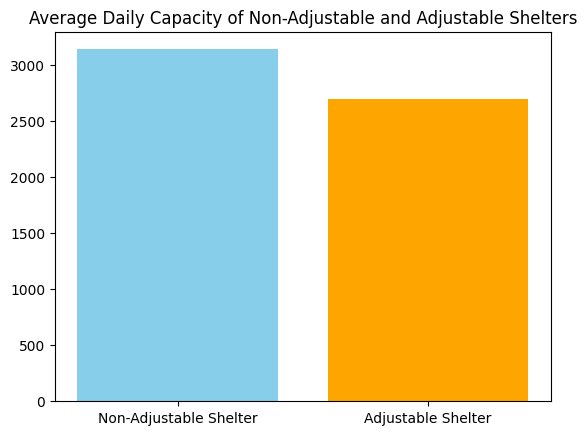

In [234]:
bar_positions = [0, 1]
bar_heights = [capacity_non_adjustable_shelter, capacity_adjustable_shelter]
bar_colors = ['skyblue', 'orange']

plt.bar(bar_positions, bar_heights, color=bar_colors)
plt.xticks(bar_positions, ['Non-Adjustable Shelter', 'Adjustable Shelter'])

plt.title('Average Daily Capacity of Non-Adjustable and Adjustable Shelters')
plt.show()

# Merged dataset 

In [235]:
merged_calls_occupancy_flow_monthly = pd.merge(average_other_daily_capacity, merged_calls_occupancy_flow_monthly, how='inner', left_index=True, right_index=True)

merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']] = merged_calls_occupancy_flow_monthly[['average_daily_total_calls', 'average_daily_unmatched_callers']].round(2)
merged_calls_occupancy_flow_monthly.tail()


,average_daily_nonadjustable_capacity,average_daily_occupancy_rate_nonadjustable,average_daily_adjustable_capacity,average_daily_occupancy_rate_adjustable,average_daily_total_calls,average_daily_unmatched_callers,newly_identified,actively_homeless,became_inactive
Date,,,,,,,,,
2023-08-01,3829.71,98.26,2483.87,99.39,888.32,244.26,539,9988,632
2023-09-01,3979.63,97.61,2471.83,99.66,979.87,277.97,841,10212,483
2023-10-01,4077.35,97.40,2496.16,99.52,1094.16,291.29,929,10111,502
2023-11-01,4132.60,97.54,2481.33,99.51,969.90,245.30,1113,10498,472
2023-12-01,4196.26,97.08,2475.77,99.55,805.94,164.74,886,10607,447


# Historical Analysis of Core Metrics

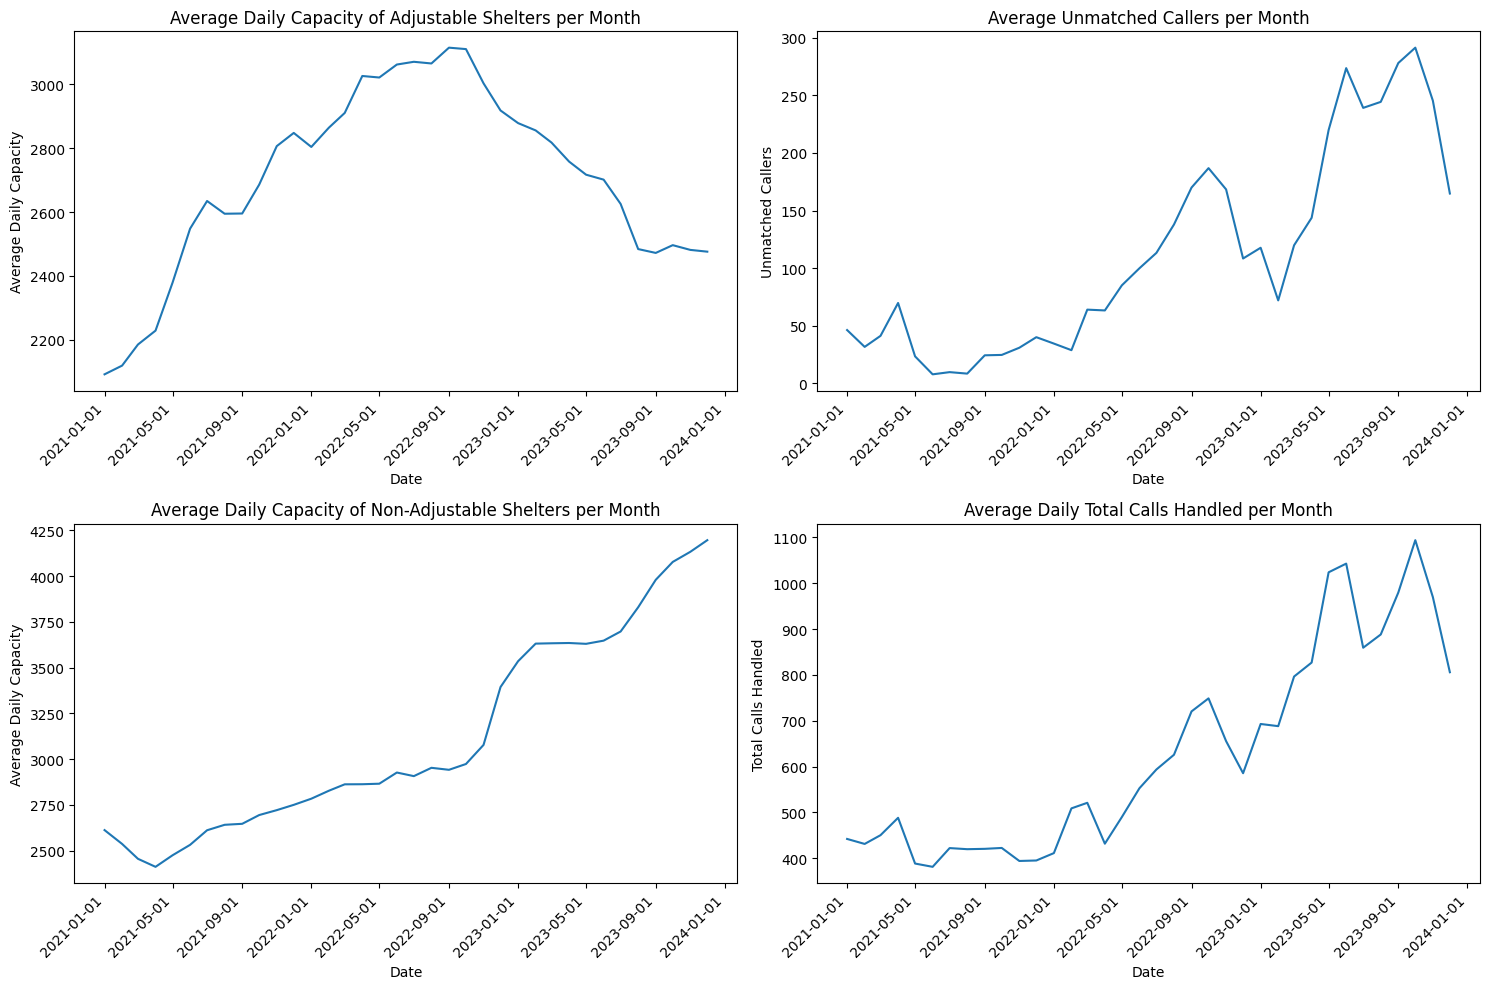

In [256]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot1 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_adjustable_capacity')
    plot1.set_xticks(plot1.get_xticks())  # Set the x-axis tick positions
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Adjustable Shelters per Month')

plt.subplot(2, 2, 2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot2 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_unmatched_callers')
    plot2.set_xticks(plot2.get_xticks())  # Set the x-axis tick positions
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Unmatched Callers')
plt.title('Average Unmatched Callers per Month')

plt.subplot(2, 2, 3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot3 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_nonadjustable_capacity')
    plot3.set_xticks(plot3.get_xticks())  # Set the x-axis tick positions
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Average Daily Capacity')
plt.title('Average Daily Capacity of Non-Adjustable Shelters per Month')

plt.subplot(2, 2, 4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot4 = sns.lineplot(data=merged_calls_occupancy_flow_monthly, x='Date', y='average_daily_total_calls')
    plot4.set_xticks(plot4.get_xticks())  # Set the x-axis tick positions
    plot4.set_xticklabels(plot4.get_xticklabels(), rotation=45, horizontalalignment='right') 
plt.xlabel('Date')
plt.ylabel('Total Calls Handled')
plt.title('Average Daily Total Calls Handled per Month')

plt.tight_layout()
plt.show()

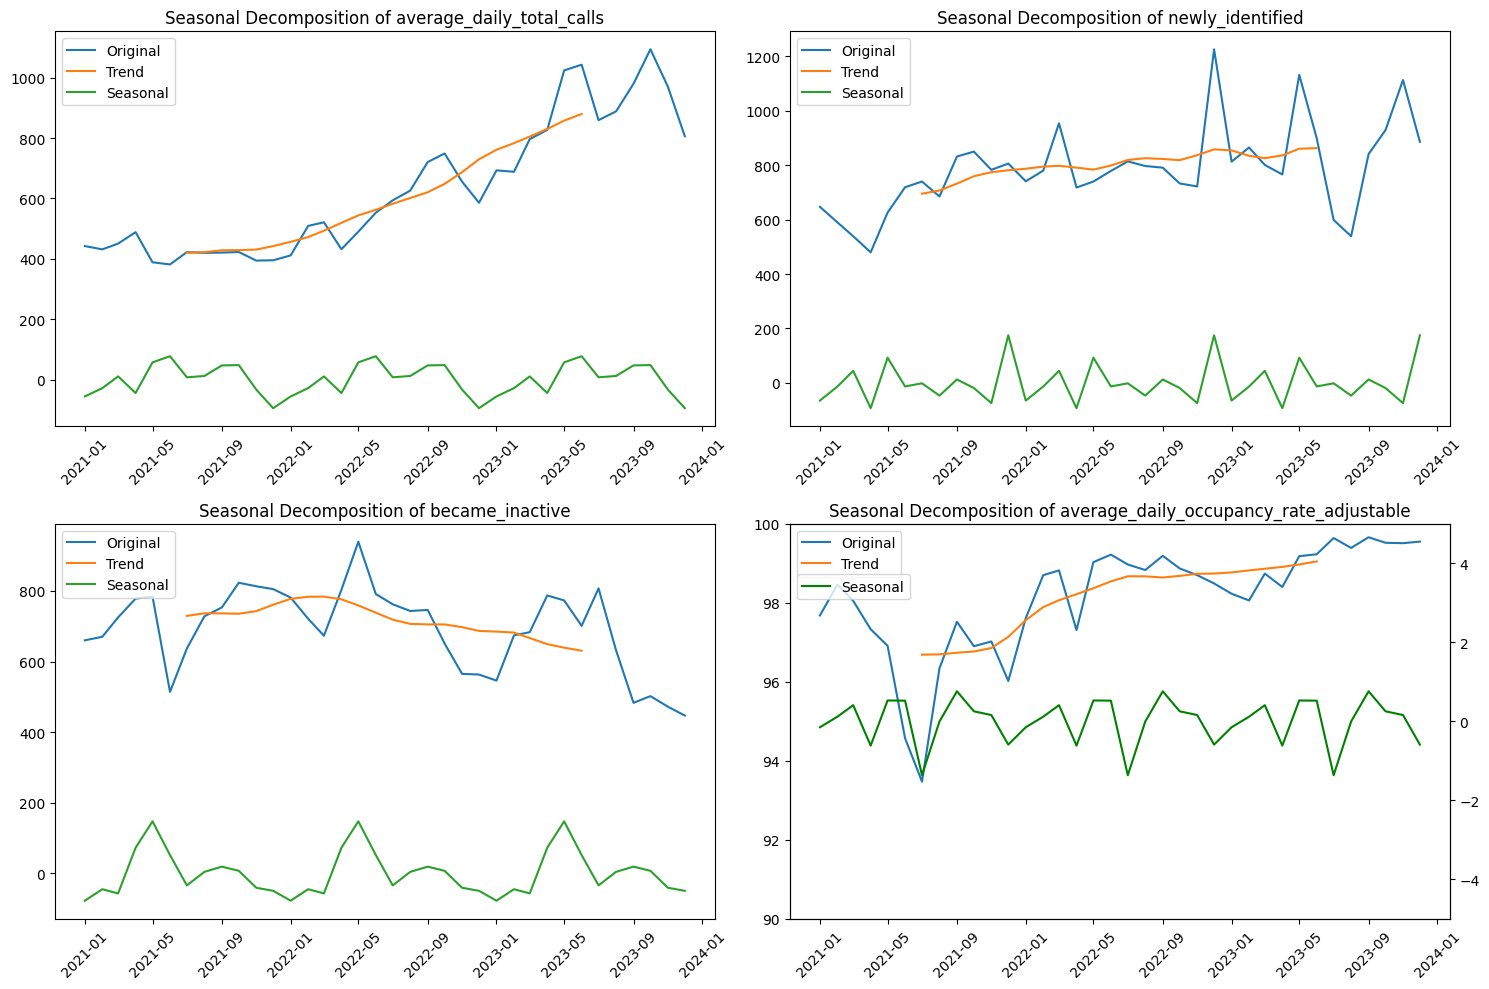

In [309]:
variables = ['average_daily_total_calls', 'newly_identified', 'became_inactive', 'average_daily_occupancy_rate_adjustable']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, variable in enumerate(variables):
    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])

    axes[i].plot(merged_calls_occupancy_flow_monthly.index, merged_calls_occupancy_flow_monthly[variable], label='Original')
    axes[i].legend()

    axes[i].plot(result.trend.index, result.trend, label='Trend')
    axes[i].legend()

    if i == len(variables) - 1:

        axes[i].set_ylim(90, 100)
        ax2 = axes[i].twinx()
        ax2.plot(result.seasonal.index, result.seasonal, label='Seasonal', color='green')  
        ax2.legend(loc='upper left',bbox_to_anchor=(0.0001, 0.89))
        ax2.set_ylim(-5, 5)  

    else:
        axes[i].plot(result.seasonal.index, result.seasonal, label='Seasonal')
        axes[i].legend(loc='upper left')

    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'Seasonal Decomposition of {variable}')

plt.tight_layout()
plt.show()


newly_identified – people who entered the shelter system for the first time <br>
became_inactive – people who were using the shelter system previously, but have not used the shelter system in the past three months.<br><br>
Seasonality is not correlated with the average number of calls. However, it is correlated with the demand for shelters – we see the spikes in the number of newly_identified shelter users in winter months; conversely, the highest number of people who stopped using shelters is observed during the summer monhts.<br><br>
Seasonality is also somewhat correlated with the adjustable occupancy rate: 17.3% compared to 2.4% for nonadjustable. This could mean that the city does indeed adjust the capacity in response to change of seasons.

# T-tests

average_daily_total_calls: 
t-statistic: -6.88893413600925
p-value: 1.7353481576535172e-07 

newly_identified: 
t-statistic: 0.16602987177514428
p-value: 0.8693265141990705 

became_inactive: 
t-statistic: -5.459332384784218
p-value: 7.913462469177361e-06 

average_daily_occupancy_rate_adjustable: 
t-statistic: -0.44383746320281786
p-value: 0.6605712129084421 



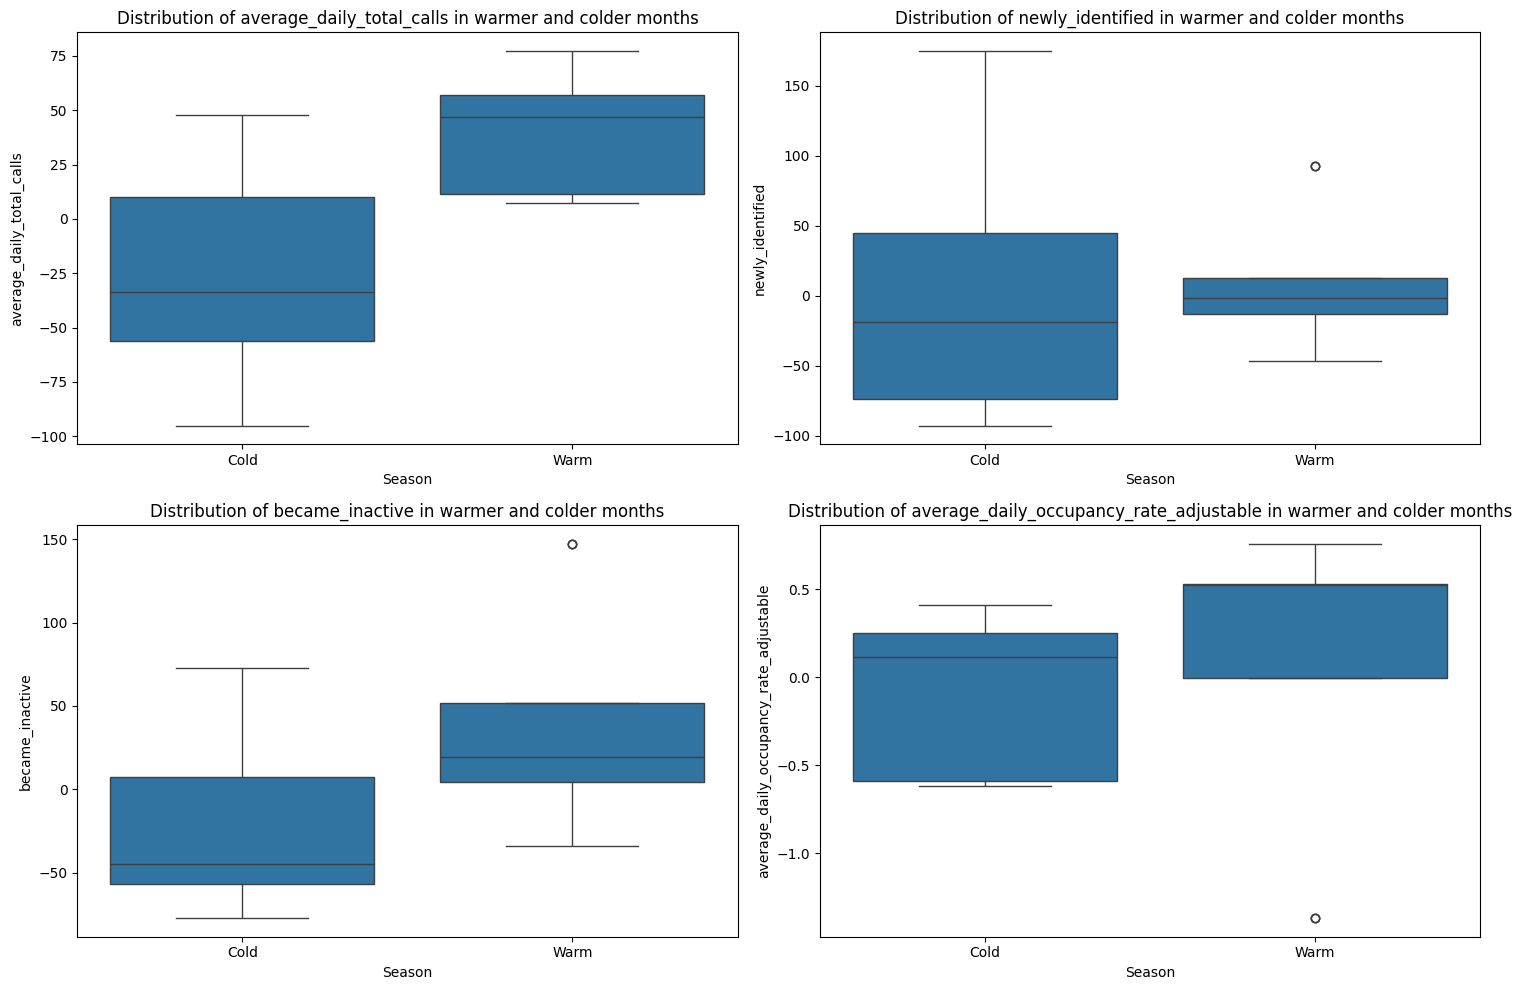

In [255]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, variable in enumerate(variables):

    result = seasonal_decompose(merged_calls_occupancy_flow_monthly[variable])
    seasonal_data = pd.DataFrame({variable: result.seasonal})
    seasonal_data['Month'] = seasonal_data.index.month

    cold_months = [11, 12, 1, 2,3]
    warm_months = [5, 6, 7, 8,9]

    winter_values = seasonal_data[seasonal_data['Month'].isin(cold_months)][variable]
    summer_values = seasonal_data[seasonal_data['Month'].isin(warm_months)][variable]

    t_statistic, p_value = ttest_ind(winter_values, summer_values)

    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(warm_months), 'Warm', 'Cold')
    seasonal_data['Season'] = np.where(seasonal_data['Month'].isin(cold_months), 'Cold', seasonal_data['Season'])

    sns.boxplot(x='Season', y=variable, data=seasonal_data, order=['Cold', 'Warm'], ax=axes[i])
    axes[i].set_title(f'Distribution of {variable} in warmer and colder months')

    print(f"{variable}: \nt-statistic: {t_statistic}")
    print("p-value:", p_value, "\n")

plt.tight_layout()
plt.show()

So far all we can infer from this data is that warmer months can be associated with the outflow of homeless people. v insightful. 